# Final Project - Part 4 - Model Draft 5B (Demo + RR vs Type of Sex Exp)

# 5B) Random Forest (Input: Demographics & Recruiter Relation; Output: Type of Sexual Exploitation)

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score,train_test_split
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
from sklearn.base import BaseEstimator
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
import random
import matplotlib.pyplot as plt
import pdb

C:\Users\ellei\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Read Cleaned Global Data
GD_data_final = pd.read_csv('assets/GD_data_final.csv')
GD_data_final.head()

,yearOfRegistration,gender,majorityStatus,ageBroad_mid,citizenshipRegion,citizenshipGeoCategory,exploitationRegion,exploitationGeoCategory,mocDebtBondage,mocTakesEarnings,...,tosProstitution,tosPornography,tosRemoteInteractiveServices,tosPrivateSexualServices,tosNotSpecified,rrIntimatePartner,rrFriend,rrFamily,rrOther,rrUnknown
0,2010,Female,Adult,19.0,Central_Asia,Asia,Central_Asia,Asia,0,0,...,0,0,0,0,1,0,0,0,0,1
1,2004,Female,Adult,19.0,Eastern_Europe,Europe,Eastern_Europe,Europe,0,0,...,0,0,0,0,1,0,0,0,0,1
2,2010,Female,Adult,19.0,Central_Asia,Asia,Central_Asia,Asia,1,0,...,0,0,0,0,1,0,0,0,0,1
3,2010,Female,Adult,19.0,Central_Asia,Asia,Central_Asia,Asia,1,0,...,0,0,0,0,1,0,0,0,0,1
4,2012,Female,Minor,13.0,North_America,North_America,North_America,North_America,0,0,...,0,0,0,0,0,0,0,1,0,0


In [3]:
GD_data_final.columns

Index([u'yearOfRegistration', u'gender', u'majorityStatus', u'ageBroad_mid',
       u'citizenshipRegion', u'citizenshipGeoCategory', u'exploitationRegion',
       u'exploitationGeoCategory', u'mocDebtBondage', u'mocTakesEarnings',
       u'mocRestrictsFinancialAccess', u'mocThreats', u'mocPsychologicalAbuse',
       u'mocPhysicalAbuse', u'mocSexualAbuse', u'mocFalsePromises',
       u'mocPsychoactiveSubstances', u'mocRestrictsMovement',
       u'mocRestrictsMedicalCare', u'mocExcessiveWorkingHours',
       u'mocUsesChildren', u'mocThreatOfLawEnforcement',
       u'mocWithholdsNecessities', u'mocWithholdsDocuments', u'mocOther',
       u'mocNotSpecified', u'isForcedLabour', u'isSexualExploit',
       u'isOtherExploit', u'isSexAndLabour', u'isForcedMarriage',
       u'isForcedMilitary', u'isOrganRemoval', u'tolAgriculture',
       u'tolAquafarming', u'tolBegging', u'tolConstruction',
       u'tolDomesticWork', u'tolHospitality', u'tolIllicitActivities',
       u'tolManufacturing', u'tolM

In [4]:
# Read Demographic vs Labor Type Data - Only for isForcedLabour == 1
demo_sexExptype_calc = pd.read_csv('assets/demo_sexExptype_calc.csv')
demo_sexExptype_calc.reset_index(drop=True)
demo_sexExptype_calc.head()

,yearOfRegistration,ageBroad_mid,g_Female,g_Male,ms_Adult,cr_Central_Asia,cr_East_Africa,cr_East_Asia,cr_Eastern_Europe,cr_Middle_East,...,cg_Europe,cg_Middle_East,cg_North_America,cg_South_America,cg_Unknown,tosProstitution,tosPornography,tosRemoteInteractiveServices,tosPrivateSexualServices,tosNotSpecified
0,2010,19.0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2004,19.0,1,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
2,2010,19.0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2010,19.0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2002,34.0,1,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1


In [5]:
demo_sexExptype_calc.columns
len(demo_sexExptype_calc)

11134

In [6]:
# Carve out Just Recruiter Relation data
GD_data_Sex = GD_data_final[GD_data_final['isSexualExploit']==1].reset_index(drop=True)
rr_sexType_handCalc = GD_data_Sex[['rrIntimatePartner','rrFriend','rrFamily','rrOther','rrUnknown']]
rr_sexType_handCalc.reset_index(drop=True)
rr_sexType_handCalc.head()
len(rr_sexType_handCalc)

11134

In [7]:
## JOIN Demographics, Means of Control, and Recruiter Relation data
#demo_rr_labortype_calc = demo_labortype_calc.join(rr_Labor_handCalc)
demo_rr_sextype_calc = pd.concat([demo_sexExptype_calc,rr_sexType_handCalc],axis=1)
demo_rr_sextype_calc.head()
demo_rr_sextype_calc.columns

Index([u'yearOfRegistration', u'ageBroad_mid', u'g_Female', u'g_Male',
       u'ms_Adult', u'cr_Central_Asia', u'cr_East_Africa', u'cr_East_Asia',
       u'cr_Eastern_Europe', u'cr_Middle_East', u'cr_North_America',
       u'cr_Northeast_Africa', u'cr_South_America', u'cr_South_Asia',
       u'cr_Southeast_Asia', u'cr_Southeastern_Europe', u'cr_Unknown',
       u'cr_West_Africa', u'cg_Africa', u'cg_Asia', u'cg_Europe',
       u'cg_Middle_East', u'cg_North_America', u'cg_South_America',
       u'cg_Unknown', u'tosProstitution', u'tosPornography',
       u'tosRemoteInteractiveServices', u'tosPrivateSexualServices',
       u'tosNotSpecified', u'rrIntimatePartner', u'rrFriend', u'rrFamily',
       u'rrOther', u'rrUnknown'],
      dtype='object')

In [8]:
### Consolidate all types of labor into one column

def combine_sexExpType(x):
    if x['tosProstitution'] == 1:
        return 'Prostitution'
    elif x['tosPornography'] == 1:
        return 'Pornography'
    elif x['tosRemoteInteractiveServices'] == 1:
        return 'RemoteInteractiveServices'
    elif x['tosPrivateSexualServices'] == 1:
        return 'PrivateSexualServices'
    elif x['tosNotSpecified'] == 1:
        return 'NotSpecified'
    else:
        return 0
        
demo_rr_sextype_calc['SexExpType'] = demo_rr_sextype_calc.apply(combine_sexExpType,axis=1)
demo_rr_sextype_calc.head()


,yearOfRegistration,ageBroad_mid,g_Female,g_Male,ms_Adult,cr_Central_Asia,cr_East_Africa,cr_East_Asia,cr_Eastern_Europe,cr_Middle_East,...,tosPornography,tosRemoteInteractiveServices,tosPrivateSexualServices,tosNotSpecified,rrIntimatePartner,rrFriend,rrFamily,rrOther,rrUnknown,SexExpType
0,2010,19.0,1,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,NotSpecified
1,2004,19.0,1,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,NotSpecified
2,2010,19.0,1,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,NotSpecified
3,2010,19.0,1,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,NotSpecified
4,2002,34.0,1,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,NotSpecified


In [9]:
demo_rr_sextype_calc[['SexExpType','tosNotSpecified']].groupby('SexExpType').count()

,tosNotSpecified
SexExpType,
NotSpecified,6776
Pornography,46
PrivateSexualServices,9
Prostitution,4303


In [10]:
print (len(demo_rr_sextype_calc), len(GD_data_Sex))

(11134, 11134)


Random Forest Train Accuracy ::  0.706916463493
Random Forest Logistic regression Test Accuracy ::  0.698892547142
Cross validating...
Random Forest - train accuracy: 
0.688317763282
X: 
Index([u'ageBroad_mid', u'g_Female', u'ms_Adult', u'cr_Central_Asia',
       u'cr_East_Africa', u'cr_East_Asia', u'cr_Eastern_Europe',
       u'cr_Middle_East', u'cr_North_America', u'cr_Northeast_Africa',
       u'cr_South_America', u'cr_South_Asia', u'cr_Southeast_Asia',
       u'cr_Southeastern_Europe', u'cr_West_Africa', u'rrIntimatePartner',
       u'rrFriend', u'rrFamily', u'rrOther'],
      dtype='object')
Feature Importance: 
[ 0.143  0.012  0.074  0.003  0.     0.034  0.399  0.     0.069  0.     0.009
  0.     0.     0.126  0.028  0.028  0.037  0.015  0.023]


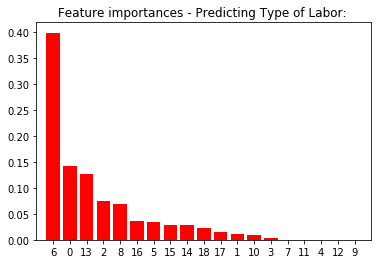

Classes: 
['NotSpecified' 'Pornography' 'PrivateSexualServices' 'Prostitution']
Average Probabilities by gender: 
        pp_NotSpecified  pp_Pornography  pp_PrivateSexualServices  \
gender                                                              
Female         0.604526        0.004288                  0.000494   
Male           0.687700        0.000083                  0.000064   

        pp_Prostitution  
gender                   
Female         0.390700  
Male           0.312149  
Average Probabilites by majorityStatus: 
                pp_NotSpecified  pp_Pornography  pp_PrivateSexualServices  \
majorityStatus                                                              
Adult                  0.674347        0.001358                  0.000666   
Minor                  0.413289        0.012290                  0.000000   

                pp_Prostitution  
majorityStatus                   
Adult                  0.323647  
Minor                  0.574404  
Average Probabilite

In [16]:
# Try OneVsRestClassifier - Multilabel classification method
def main():
    #headers = ['ageBroad_mid', 'g_Female', 'ms_Adult', 
                              #'cr_Central_Asia', 'cr_East_Africa', 'cr_East_Asia', 'cr_Eastern_Europe', 'cr_Middle_East', 
                              #'cr_North_America', 'cr_Northeast_Africa', 'cr_South_America', 'cr_South_Asia', 
                              #'cr_Southeast_Asia', 'cr_Southeastern_Europe', 'cr_West_Africa', 
                              #'cg_Africa', 'cg_Asia', 'cg_Europe', 'cg_Middle_East', 'cg_North_America', 'cg_South_America', 
                                #'rrIntimatePartner', 'rrFriend', 'rrFamily', 'rrOther',
                              # 'LaborType']
    headers = ['ageBroad_mid','g_Female', 'ms_Adult',
                              'cr_Central_Asia', 'cr_East_Africa', 'cr_East_Asia', 'cr_Eastern_Europe', 'cr_Middle_East', 
                              'cr_North_America', 'cr_Northeast_Africa', 'cr_South_America', 'cr_South_Asia', 
                              'cr_Southeast_Asia', 'cr_Southeastern_Europe', 'cr_West_Africa',    
                                'rrIntimatePartner', 'rrFriend', 'rrFamily', 'rrOther', 
                                 'SexExpType']
    
    ### Train Test Split - Out put col index -1 
    X = demo_rr_sextype_calc[headers[:-1]]
    y = demo_rr_sextype_calc[headers[-1]]
    train_x, test_x, train_y, test_y = train_test_split(X, y, train_size=0.7)
    
    model = RandomForestClassifier(n_estimators=500)
    model.fit(train_x, train_y)

    print "Random Forest Train Accuracy :: ", metrics.accuracy_score(train_y, model.predict(train_x))
    print "Random Forest Logistic regression Test Accuracy :: ", metrics.accuracy_score(test_y, model.predict(test_x))
    
    print ("Cross validating...")
    print ("Random Forest - train accuracy: ")
    print (np.mean(cross_val_score(model, train_x, train_y.values, scoring='accuracy', cv=10)))

    print ("X: ")
    print (X.columns)
    
    #Feature Importances - Break down weights of each feature
    print ("Feature Importance: ")
    importances = model.feature_importances_.round(3)
    print (importances)
    
    ## Graphing Feature Importances
    std = np.std([importances],axis=0)
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances - Predicting Type of Labor: ")
    plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()
    
    print ("Classes: ")
    print (model.classes_)
    
    
    # Predict Probabilities
    #pp = model.predict_proba(X)    
    cols = ['pp_NotSpecified', 'pp_Pornography', 'pp_PrivateSexualServices', 'pp_Prostitution']    
    df_pp = pd.DataFrame(model.predict_proba(X).round(4),columns=cols)
    df_data_pp = GD_data_Sex.join(df_pp)
    #df_pp.head()
    
    # GROUP BYs different demographics
    print ("Average Probabilities by gender: ")
    print (df_data_pp[['gender','pp_NotSpecified', 'pp_Pornography', 'pp_PrivateSexualServices', 'pp_Prostitution']].groupby('gender').mean())

    print ("Average Probabilites by majorityStatus: ")
    print (df_data_pp[['majorityStatus','pp_NotSpecified', 'pp_Pornography', 'pp_PrivateSexualServices', 'pp_Prostitution']].groupby('majorityStatus').mean())
    
    print ("Average Probabilites by ageBroad_mid: ")
    print (df_data_pp[['ageBroad_mid','pp_NotSpecified', 'pp_Pornography', 'pp_PrivateSexualServices', 'pp_Prostitution']].groupby('ageBroad_mid').mean())
    
    print ("Average Probabilites by citizenshipRegion: ")
    print (df_data_pp[['citizenshipRegion','pp_NotSpecified', 'pp_Pornography', 'pp_PrivateSexualServices', 'pp_Prostitution']].groupby('citizenshipRegion').mean())
    
   
if __name__ == '__main__':
  main()